# 训练你的物体检测器

In [ ]:
!pip install gluoncv

In [1]:
import gluoncv as gcv
import mxnet as mx

# 准备训练集

In [2]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'juice', 'noodles', 'hand']  # , 'cocacola-zero'
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('../images/v4')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['cocacola', 'juice', 'noodles', 'hand']
num_images: 117


# 可视化数据

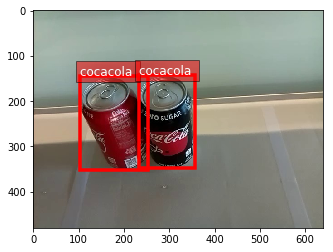

In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()


# 定义训练过程

In [4]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
    ctx = mx.gpu(0)
#     ctx = mx.cpu(0)
    net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_dataset.classes, transfer='coco')
    #net.load_parameters('object_detector_epoch100_10_23_2019_21_59_13.params')  # TODO continue training
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    gcv.utils.random.seed(233)
    
#     batch_size = 4
    batch_size = 8  # 16 for p3.2xlarge, 8 for p2.2xlarge
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    train_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    sigmoid_ce = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    l1_loss = mx.gluon.loss.L1Loss()
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')
    for k, v in net.collect_params().items():
        if 'yolodetectionblock' not in k and 'yolooutput' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.0005, 'wd': 0.0005, 'momentum': 0.9})  # 'learning_rate': 0.001
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            batch_size = batch[0].shape[0]
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [mx.gluon.utils.split_and_load(batch[it], ctx_list=[ctx], batch_axis=0) for it in range(1, 6)]
            gt_boxes = mx.gluon.utils.split_and_load(batch[6], ctx_list=[ctx], batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
            btic = time.time()
    return net
        


# 开始训练

In [5]:
epochs = 100
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

[Epoch 0][Batch 0], LR: 5.00E-04, Speed: 0.432 samples/sec, ObjLoss=1.909, BoxCenterLoss=7.538, BoxScaleLoss=1.343, ClassLoss=1.212
[Epoch 0][Batch 1], LR: 5.00E-04, Speed: 14.011 samples/sec, ObjLoss=2.383, BoxCenterLoss=7.736, BoxScaleLoss=1.288, ClassLoss=1.190
[Epoch 0][Batch 2], LR: 5.00E-04, Speed: 13.827 samples/sec, ObjLoss=2.541, BoxCenterLoss=9.000, BoxScaleLoss=1.412, ClassLoss=1.169
[Epoch 0][Batch 3], LR: 5.00E-04, Speed: 13.882 samples/sec, ObjLoss=2.256, BoxCenterLoss=7.681, BoxScaleLoss=1.227, ClassLoss=0.977
[Epoch 0][Batch 4], LR: 5.00E-04, Speed: 13.600 samples/sec, ObjLoss=2.243, BoxCenterLoss=8.017, BoxScaleLoss=1.261, ClassLoss=0.936
[Epoch 0][Batch 5], LR: 5.00E-04, Speed: 13.321 samples/sec, ObjLoss=2.441, BoxCenterLoss=8.654, BoxScaleLoss=1.321, ClassLoss=1.075
[Epoch 0][Batch 6], LR: 5.00E-04, Speed: 13.592 samples/sec, ObjLoss=2.423, BoxCenterLoss=8.529, BoxScaleLoss=1.294, ClassLoss=1.068
[Epoch 0][Batch 7], LR: 5.00E-04, Speed: 13.669 samples/sec, ObjLoss=2